In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## **Loading dataset**



In [53]:
from torchvision import datasets, transforms
use_cuda = True

device = torch.device("cuda" if use_cuda else "cpu")

train_batch_size=64
test_batch_size=1000

transform = transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('data', train=True, download=True, transform=transform),
                    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('data', train=False, transform=transform),
                    batch_size=test_batch_size, shuffle=True, **kwargs)

visualize_loader = torch.utils.data.DataLoader(datasets.CIFAR10('data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])),
                    batch_size=train_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


## **Visualize some images**

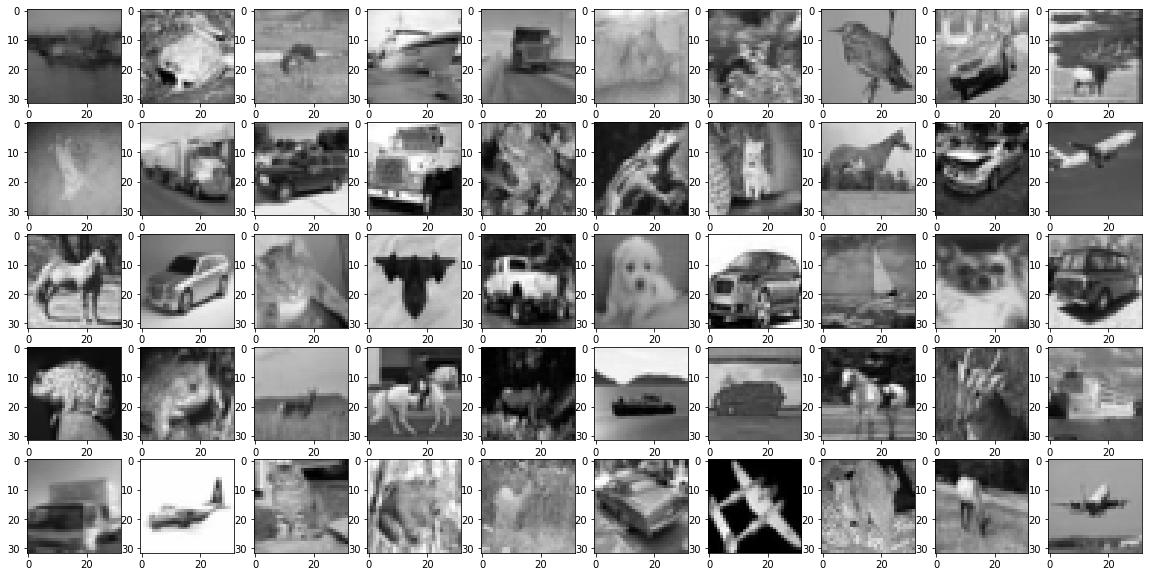

In [54]:
# visualize data
fig=plt.figure(figsize=(20, 10))
data, label = next(iter(visualize_loader))
for i in range(1, 51):
    img = data[i][0]
    fig.add_subplot(5, 10, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.show()

## **Model definition**

In [0]:
# First model
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(784, 10)

#     def forward(self, x):
#         x = x.view(-1, 784)
#         x = self.fc1(x)
#         return F.log_softmax(x, dim=1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(3, 20, 3, padding=1)
        self.bnm0 = nn.BatchNorm2d(20)
        self.conv1 = nn.Conv2d(20, 80, 3)
        self.bnm1 = nn.BatchNorm2d(80)
        self.conv2 = nn.Conv2d(80, 240, 4)
        self.bnm2 = nn.BatchNorm2d(240)
        self.conv3 = nn.Conv2d(240, 900, 3)
        self.bnm3 = nn.BatchNorm2d(900)
        self.conv4 = nn.Conv2d(900, 2000, 3)
        self.bnm4 = nn.BatchNorm2d(2000)
        self.conv5 = nn.Conv2d(2000, 2000, 3, padding=1)
        self.bnm5 = nn.BatchNorm2d(2000)
        self.conv6 = nn.Conv2d(2000, 3000, 3, padding=1)
        self.bnm6 = nn.BatchNorm2d(3000)
        
        self.fc1 = nn.Linear(2*2*3000, 3200)
        self.fc2 = nn.Linear(3200, 10)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.bnm0(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.bnm1(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.bnm2(x)
        x = F.relu(self.conv3(x))
        x = self.bnm3(x)
        x = F.relu(self.conv4(x))
        x = self.bnm4(x)
        x = F.relu(self.conv5(x))
        x = self.bnm5(x)
        x = F.relu(self.conv6(x))
        x = self.bnm6(x)
       

        x = x.view(-1,2*2*3000)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## **Optimizer**

In [0]:
import torch.optim as optim

lr=0.08
momentum = 0.5

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

## **Functions for train and test model**

In [0]:
def train(model, device, train_loader, optimizer, epoch,log_interval):
    model.train()
    avg_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # zero the gradient buffers
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step() # Does the update
        avg_loss+=F.nll_loss(output, target, reduction='sum').item()
        
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{:5.0f}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
    avg_loss/=len(train_loader.dataset)
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    accuracy = 100. * correct / len(test_loader.dataset)
    time.sleep(0.2)
    return test_loss,accuracy

## **Training model**

In [0]:
epochs = 17
log_interval = 47
save_model = False

In [59]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [60]:
train_losses = []
test_losses = []
accuracy_list = []
for epoch in range(1, epochs + 1):
    trn_loss = train(model, device, train_loader, optimizer, epoch,log_interval)
    test_loss,accuracy = test(model, device, test_loader)
    train_losses.append(trn_loss)
    test_losses.append(test_loss)
    accuracy_list.append(accuracy)
    if epoch==2 or epoch==3 or epoch==4 or epoch==8 or epoch==10 or epoch==11 or epoch==14 or epoch==15 or epoch==16 or epoch==5 :
      lr=lr/1.3
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    if epoch%100 == 0:
        net_save_name = 'CIFAR10_epoch_'+str(epoch)+'.pt'
        path = F"/content/gdrive/My Drive/{net_save_name}" 
        torch.save(copy.deepcopy(model.state_dict()), path)


if (save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [    0/50000 (0%)]	Loss: 2.313174
Train Epoch: 1 [ 3008/50000 (6%)]	Loss: 2.347072
Train Epoch: 1 [ 6016/50000 (12%)]	Loss: 2.088255
Train Epoch: 1 [ 9024/50000 (18%)]	Loss: 1.929123
Train Epoch: 1 [12032/50000 (24%)]	Loss: 1.980357
Train Epoch: 1 [15040/50000 (30%)]	Loss: 1.795529
Train Epoch: 1 [18048/50000 (36%)]	Loss: 1.742809
Train Epoch: 1 [21056/50000 (42%)]	Loss: 1.626435
Train Epoch: 1 [24064/50000 (48%)]	Loss: 1.450868
Train Epoch: 1 [27072/50000 (54%)]	Loss: 1.535477
Train Epoch: 1 [30080/50000 (60%)]	Loss: 1.519518
Train Epoch: 1 [33088/50000 (66%)]	Loss: 1.393092
Train Epoch: 1 [36096/50000 (72%)]	Loss: 1.375867
Train Epoch: 1 [39104/50000 (78%)]	Loss: 1.223464
Train Epoch: 1 [42112/50000 (84%)]	Loss: 1.274612
Train Epoch: 1 [45120/50000 (90%)]	Loss: 1.225884
Train Epoch: 1 [48128/50000 (96%)]	Loss: 1.321281

Test set: Average loss: 1.7547, Accuracy: 4079/10000 (40.8%)

Train Epoch: 2 [    0/50000 (0%)]	Loss: 1.455565
Train Epoch: 2 [ 3008/50000 (6%)]	Loss: 